In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load the original and synthetic data from CSV files
original_data_file_path = 'C:/Users/raghu/CS6140/PEMS-BAY.csv'
synthetic_data_file_path = 'C:/Users/raghu/CS6140/synthetic_data_timegan_72.csv'
# synthetic_data_file_path = 'C:/Users/raghu/CS6140/synthetic_data_SDVGaussian.csv'

original_data_df = pd.read_csv(original_data_file_path)
synthetic_data_df = pd.read_csv(synthetic_data_file_path)
print(original_data_df.shape)
print(synthetic_data_df.shape)

(52116, 326)
(5376, 326)


In [33]:
# Convert timestamp to datetime and set as index
original_data_df['Timestamp'] = pd.to_datetime(original_data_df['Timestamp'])
original_data_df.set_index('Timestamp', inplace=True)

# Define the timestamp limit for comparison
timestamp_limit = pd.to_datetime('2017-01-19 15:55:00')
original_data_df = original_data_df.loc[:timestamp_limit]

# Convert timestamp to datetime and set as index
synthetic_data_df['Timestamp'] = pd.to_datetime(synthetic_data_df['Timestamp'])
synthetic_data_df.set_index('Timestamp', inplace=True)

# Check the lengths of the original and synthetic data
print(f"Original data length: {len(original_data_df)}")
print(f"Synthetic data length: {len(synthetic_data_df)}")

Original data length: 5376
Synthetic data length: 5376


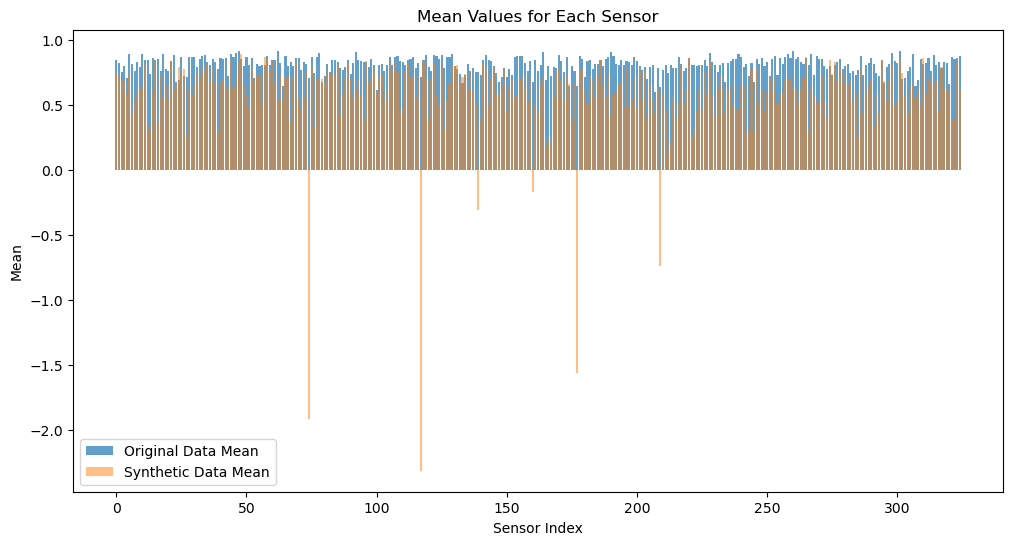

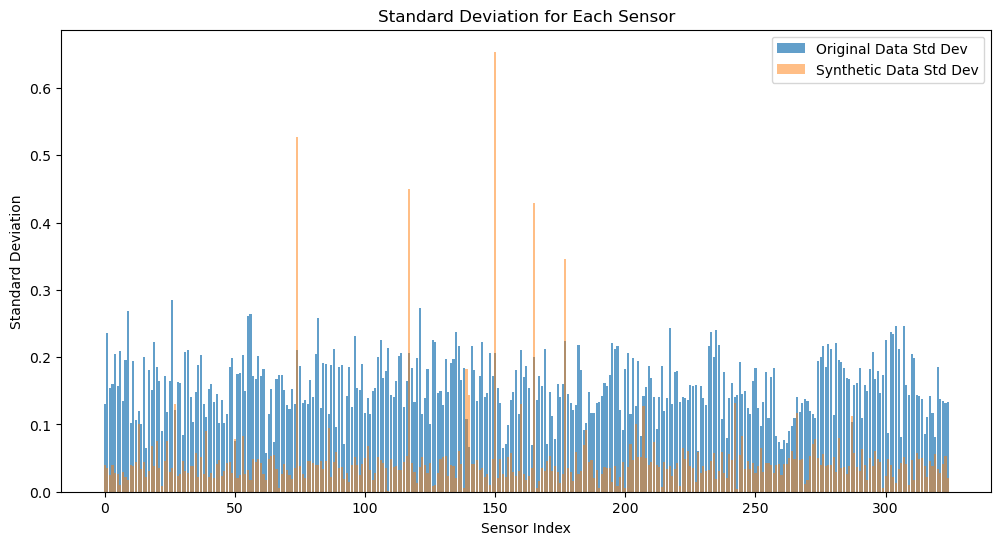

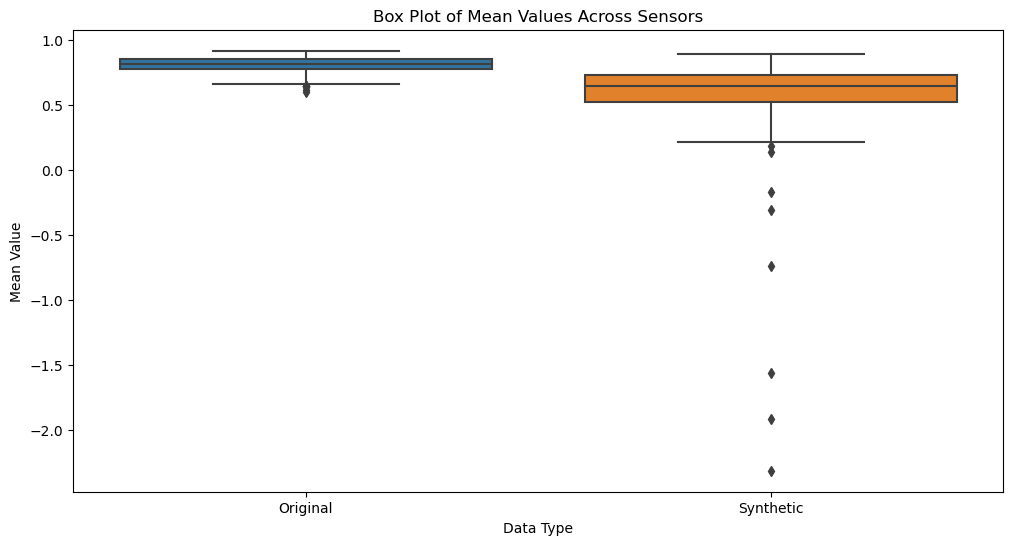

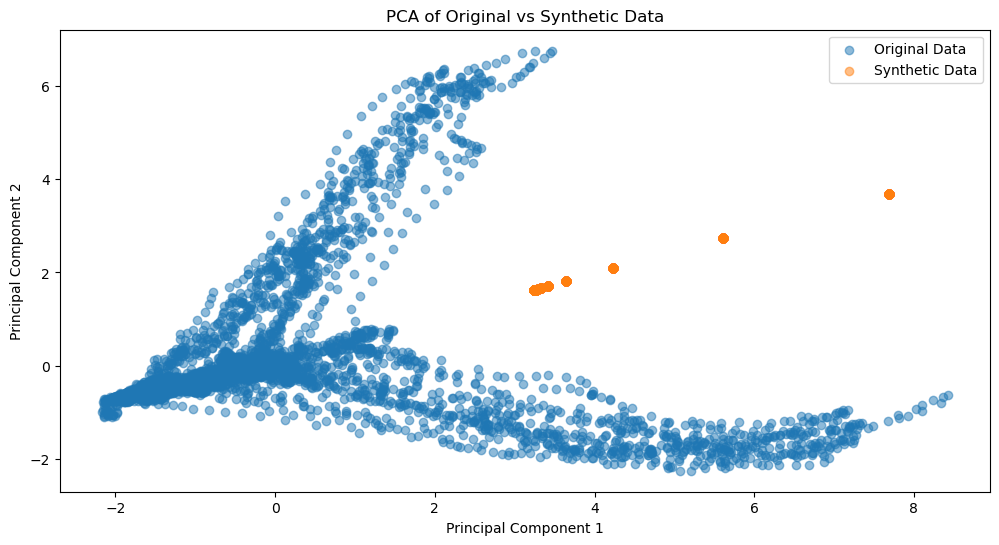

In [35]:
import seaborn as sns
from sklearn.decomposition import PCA
# Subset the original data to match the length of the synthetic data
original_data_df = original_data_df.iloc[:len(synthetic_data_df)]

# Now, you can safely assert that the lengths are equal
assert len(original_data_df) == len(synthetic_data_df), "Original and synthetic data must have the same length"

# Proceed with further comparisons


# Extract numerical data for comparison
original_data = original_data_df.values
synthetic_data = synthetic_data_df.values

# Optionally, scale the data if it was scaled before generating synthetic data
scaler = MinMaxScaler()
original_data = scaler.fit_transform(original_data)
synthetic_data = scaler.transform(synthetic_data)

# Statistical Comparison
def calculate_statistics(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return mean, std

original_mean, original_std = calculate_statistics(original_data)
synthetic_mean, synthetic_std = calculate_statistics(synthetic_data)

# Plot Mean Values for Each Sensor
plt.figure(figsize=(12, 6))
plt.bar(range(len(original_mean)), original_mean, alpha=0.7, label='Original Data Mean')
plt.bar(range(len(synthetic_mean)), synthetic_mean, alpha=0.5, label='Synthetic Data Mean')
plt.xlabel('Sensor Index')
plt.ylabel('Mean')
plt.title('Mean Values for Each Sensor')
plt.legend()
plt.show()

# Plot Standard Deviation for Each Sensor
plt.figure(figsize=(12, 6))
plt.bar(range(len(original_std)), original_std, alpha=0.7, label='Original Data Std Dev')
plt.bar(range(len(synthetic_std)), synthetic_std, alpha=0.5, label='Synthetic Data Std Dev')
plt.xlabel('Sensor Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation for Each Sensor')
plt.legend()
plt.show()

# Box Plot of Mean Values Across Sensors
plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.DataFrame({'Original': original_mean, 'Synthetic': synthetic_mean}))
plt.title('Box Plot of Mean Values Across Sensors')
plt.xlabel('Data Type')
plt.ylabel('Mean Value')
plt.show()

# PCA Visualization of Sensor Data
pca = PCA(n_components=2)
pca_result_original = pca.fit_transform(original_data)
pca_result_synthetic = pca.transform(synthetic_data)

plt.figure(figsize=(12, 6))
plt.scatter(pca_result_original[:, 0], pca_result_original[:, 1], alpha=0.5, label='Original Data')
plt.scatter(pca_result_synthetic[:, 0], pca_result_synthetic[:, 1], alpha=0.5, label='Synthetic Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Original vs Synthetic Data')
plt.legend()
plt.show()


     KS Statistic  P-value
0        0.885975      0.0
1        0.870164      0.0
2        0.726004      0.0
3        0.869792      0.0
4        0.837798      0.0
..            ...      ...
320      0.782738      0.0
321      0.976935      0.0
322      0.984561      0.0
323      0.738281      0.0
324      0.958705      0.0

[325 rows x 2 columns]
Plotting histogram for Feature 0 (400201)
Plotting histogram for Feature 1 (400298)
Plotting histogram for Feature 2 (414694)


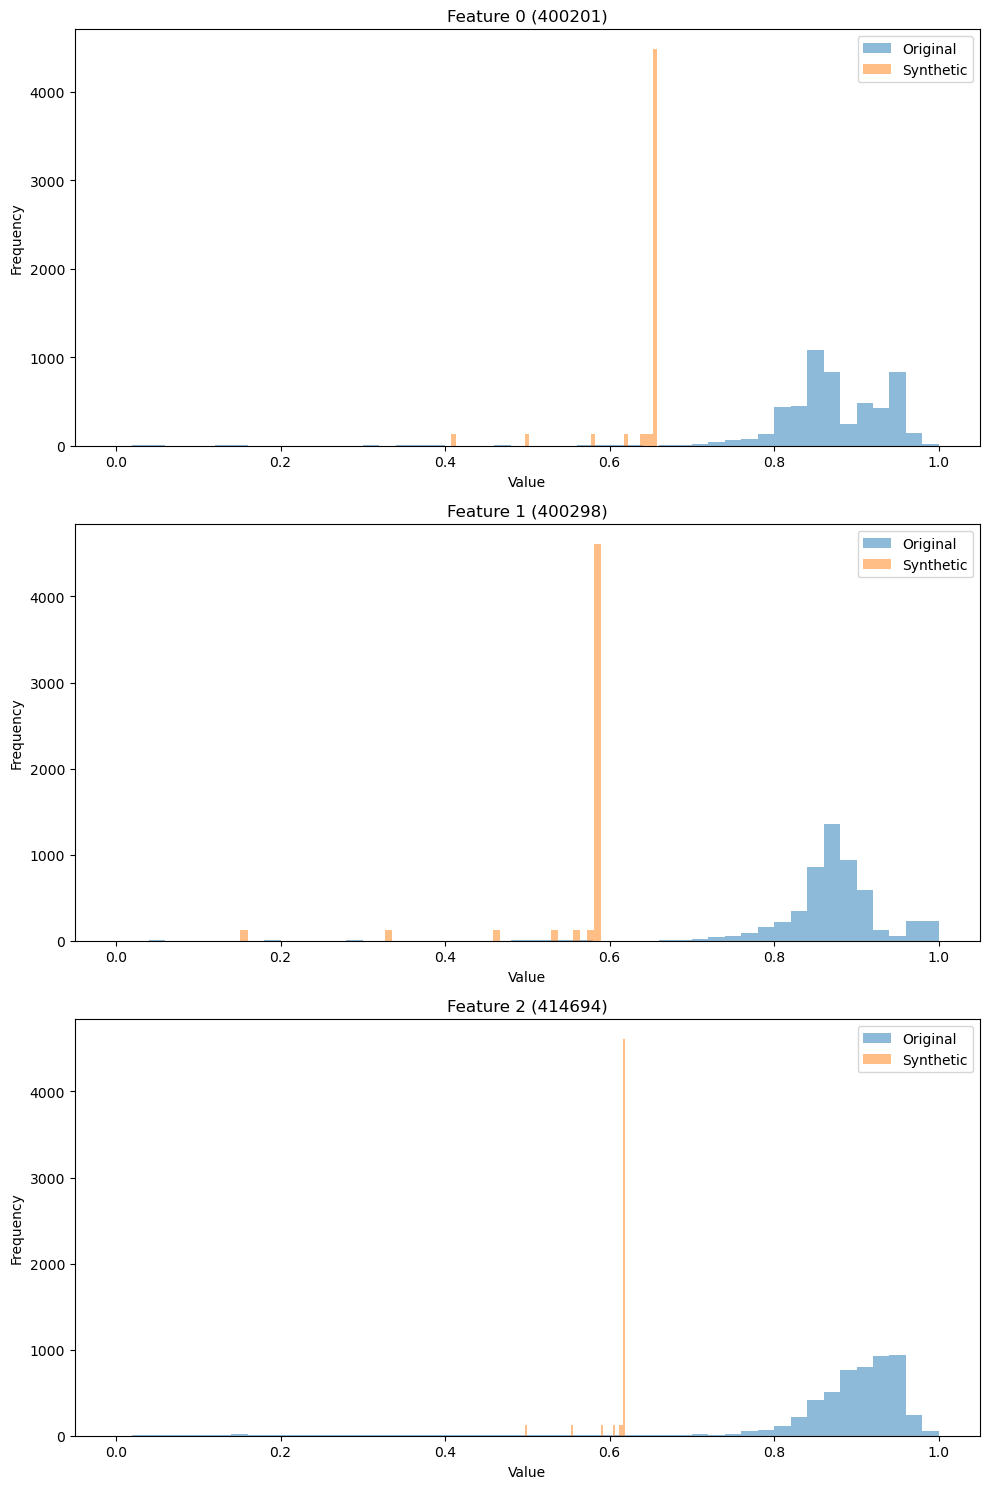

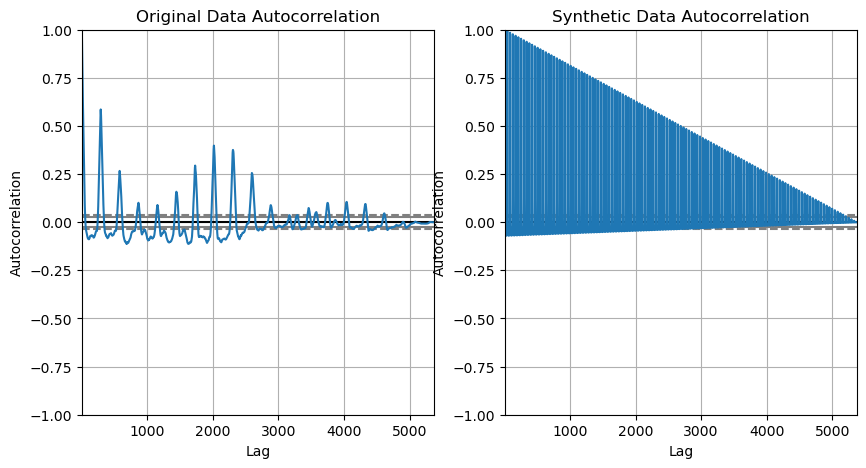

In [37]:
# Kolmogorov-Smirnov Test
ks_statistics = [ks_2samp(original_data[:, i], synthetic_data[:, i]) for i in range(original_data.shape[1])]
ks_results = pd.DataFrame(ks_statistics, columns=['KS Statistic', 'P-value'])

print(ks_results)
feature_names = original_data_df.columns
# Visual Comparison - Histograms
def plot_histograms(original, synthetic, features, feature_names, num_bins=50):
    fig, axes = plt.subplots(len(features), 1, figsize=(10, 5 * len(features)))
    if len(features) == 1:
        axes = [axes]
    
    for i, feature in enumerate(features):
        column_name = feature_names[feature]  # Get the actual column name for the feature
        print(f"Plotting histogram for Feature {i} ({column_name})")  # Print the column name
        
        axes[i].hist(original[:, feature], bins=num_bins, alpha=0.5, label='Original')
        axes[i].hist(synthetic[:, feature], bins=num_bins, alpha=0.5, label='Synthetic')
        axes[i].set_title(f'Feature {i} ({column_name})')
        axes[i].set_xlabel('Value')  # X-axis label
        axes[i].set_ylabel('Frequency')  # Y-axis label
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
# Plot histograms for a few features
plot_histograms(original_data, synthetic_data, features=[30, 50, 324], feature_names=feature_names )

# Visual Comparison - Autocorrelation
def plot_autocorrelation(original, synthetic, feature_idx):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    autocorrelation_plot(pd.Series(original[:, feature_idx]))
    plt.title('Original Data Autocorrelation')

    plt.subplot(1, 2, 2)
    autocorrelation_plot(pd.Series(synthetic[:, feature_idx]))
    plt.title('Synthetic Data Autocorrelation')
    plt.show()

# Plot autocorrelation for a specific feature
plot_autocorrelation(original_data, synthetic_data, feature_idx=0)



Strong Initial Correlation: At lag 0, the autocorrelation is 1, which is expected since any series is perfectly correlated with itself. As the lag increases, the autocorrelation decreases but remains significant for a substantial number of lags.
Periodic Pattern: There is a noticeable periodic pattern in the autocorrelation values. This suggests that there are repeating patterns or cycles within the data at regular intervals. The peaks at regular intervals indicate a strong seasonal or cyclic component in the dataset.
Long-term Dependencies: The autocorrelation values remain significant for many lags, indicating that the time-series data has long-term dependencies. This means that the values at a given time are influenced by values from many previous time steps.